In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import NDArray
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.multioutput import MultiOutputRegressor
import pandas as pd

In [2]:
# 価格を生成する関数
def create_price(r_min: float, r_max: float, M: int) -> NDArray[np.float_]:
    # r_minとr_maxの間のランダムな0.1刻みの少数をM個生成
    price = np.random.uniform(r_min, r_max, M)
    price = np.round(price, 1)

    return price


# alphaを作成する関数
def alpha_star(M: int) -> NDArray[np.float_]:
    alpha_star = np.random.uniform(M, 3 * M, size=M)
    return alpha_star


# betaを作成する関数
def beta_star(M: int, M_prime: int) -> NDArray[np.float_]:
    beta_star = np.zeros((M, M_prime))

    for m in range(M):
        for m_prime in range(M_prime):
            if m == m_prime:
                beta_star[m, m_prime] = np.random.uniform(-2 * M, -M)
            else:
                beta_star[m, m_prime] = np.random.uniform(0, 1)

    return beta_star


def quantity_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    quantity_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta + 1 * np.random.normal(0, 5)
        quantity_list.append(quantity)
    # print("quantity_list", quantity_list)

    return quantity_list


def sales_function(
    price: NDArray[np.float_], alpha: NDArray[np.float_], beta: NDArray[np.float_]
) -> list[float]:
    M = len(price)
    sales_list = []

    for m in range(M):
        sum_beta = 0
        for m_prime in range(M):
            sum_beta += beta[m][m_prime] * price[m_prime]

        quantity = alpha[m] + sum_beta
        sales_list.append(quantity * price[m])

    return sales_list

In [3]:
from scipy.optimize import minimize


# 予測と最適化を行う関数
def predict_optimize(
    M: int, X: NDArray[np.float_], Y: NDArray[np.float_], prices_list: list[float]
) -> tuple[float, NDArray[np.float_]]:
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)
    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    def objective_function(prices):
        return -sum(
            prices[m]
            * (intercepts[m] + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M)))
            for m in range(M)
        )

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 各価格の範囲を設定（0.6から1.0）
    bounds = [(0.6, 1.0) for _ in range(M)]
    # 最適化を実行
    result = minimize(objective_function, initial_prices, bounds=bounds, method="SLSQP")
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices

In [4]:
# # sales_optimizeの最適化を行う関数
# def sales_optimize(
#     M: int,
#     alpha: NDArray[np.float_],
#     beta: NDArray[np.float_],
#     prices_list: list[float],
# ) -> tuple[float, NDArray[np.float_]]:
#     objective = sum(
#         prices_list[m]
#         * (
#             alpha[m]
#             + sum(beta[m][m_prime] * prices_list[m_prime] for m_prime in range(M))
#         )
#         for m in range(M)
#     )
#     # objectiveを最大にする価格を求める
import numpy as np


# sales_optimizeの最適化を行う関数
def sales_optimize(
    M: int,
    alpha: np.ndarray,
    beta: np.ndarray,
    prices_list: list[float],
) -> tuple[float, np.ndarray]:
    # 目的関数を定義（最大化問題を最小化問題に変換）
    def objective_function(prices):
        return -sum(
            prices[m]
            * (alpha[m] + sum(beta[m][m_prime] * prices[m_prime] for m_prime in range(M)))
            for m in range(M)
        )

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.6)
    # 各価格の範囲を設定（0.6から1.0）
    bounds = [(0.6, 1.0) for _ in range(M)]
    # 最適化を実行
    result = minimize(objective_function, initial_prices, bounds=bounds, method="SLSQP")
    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す
    return optimal_value, optimal_prices

In [5]:
# CVを行う関数
def cross_validation(
    X: NDArray[np.float_],
    y: NDArray[np.float_],
    M: int,
    K: int,
    prices_list: list[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []
    Z = len(prices_list)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())

        # 係数、切片を取得
        lr_tilda.fit(X_train, y_train)
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        def objective_function(prices):
            return -sum(
                prices[m]
                * (
                    intercepts[m]
                    + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M))
                )
                for m in range(M)
            )

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.6)
        # 各価格の範囲を設定（0.6から1.0）
        bounds = [(0.6, 1.0) for _ in range(M)]
        # 最適化を実行
        result = minimize(objective_function, initial_prices, bounds=bounds, method="SLSQP")
        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)

In [6]:
# このデータにおけるalpha,betaを作成
M = 50
alpha = alpha_star(M)
beta = beta_star(M, M)
r_m = 0.6
r_M = 1.0
# 価格を入れるリスト
price_list = []
# 売上を入れるリスト
sales_list = []

# 価格と対応する売上を500件生成
for i in range(500):
    price = create_price(r_m, r_M, M)
    price_list.append(price)
    sales = quantity_function(price, alpha, beta)
    sales_list.append(sales)

X = np.array(price_list).astype(float)
y = np.array(sales_list).astype(float)

In [7]:
z = [0.6, 0.7, 0.8, 0.9, 1.0]

<BarContainer object of 4 artists>

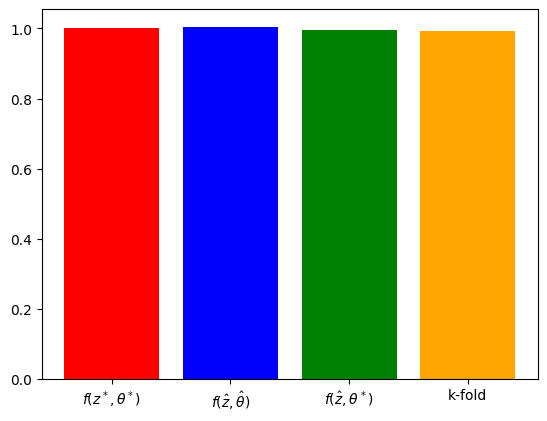

In [8]:
# 100回繰り返して結果をlistに格納
sales_optimize_sales_list_50 = []
predict_optimize_sales_list_50 = []
predict_sales_list_50 = []
cross_validation_sales_list_50 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 50
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # predict_optimazeの結果を取得
    predict_optimize_sales, predict_optimize_prices = predict_optimize(M, X, y, z)
    # sales_optimizeの結果を取得
    sales_optimize_sales, sales_optimize_prices = sales_optimize(M, alpha, beta, z)
    # cross_validationの結果を取得
    cross_validation_sales = cross_validation(X, y, M, 5, z)

    # predictoptimize_salesをsales_functionに代入
    predict_sales = sum(sales_function(predict_optimize_prices, alpha, beta))

    sales_optimize_sales_list_50.append(sales_optimize_sales)
    predict_optimize_sales_list_50.append(predict_optimize_sales)
    predict_sales_list_50.append(predict_sales)
    cross_validation_sales_list_50.append(cross_validation_sales)

# 結果を図示(平均)
plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_optimize_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.mean(predict_optimize_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.mean(predict_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.mean(cross_validation_sales_list_50) / np.mean(sales_optimize_sales_list_50),
    ],
    color=["red", "blue", "green", "orange"],
)

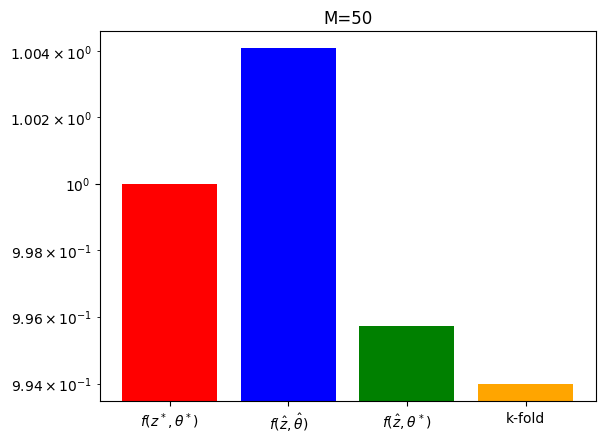

In [9]:
# 結果を図示(平均)
plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_optimize_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.mean(predict_optimize_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.mean(predict_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.mean(cross_validation_sales_list_50) / np.mean(sales_optimize_sales_list_50),
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")
plt.title("M=50")

plt.show()

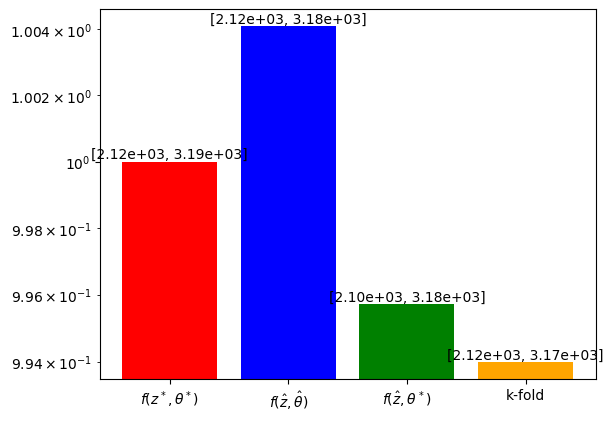

In [10]:
# 棒グラフのデータ
labels = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\hat\theta)$",
    r"$f(\hat{z},\theta^*)$",
    r"k-fold",
]
means = [
    np.mean(sales_optimize_sales_list_50) / np.mean(sales_optimize_sales_list_50),
    np.mean(predict_optimize_sales_list_50) / np.mean(sales_optimize_sales_list_50),
    np.mean(predict_sales_list_50) / np.mean(sales_optimize_sales_list_50),
    np.mean(cross_validation_sales_list_50) / np.mean(sales_optimize_sales_list_50),
]
ranges = [
    (np.min(sales_optimize_sales_list_50), np.max(sales_optimize_sales_list_50)),
    (np.min(predict_optimize_sales_list_50), np.max(predict_optimize_sales_list_50)),
    (np.min(predict_sales_list_50), np.max(predict_sales_list_50)),
    (np.min(cross_validation_sales_list_50), np.max(cross_validation_sales_list_50)),
]

# 棒グラフの描画
plt.bar(labels, means, color=["red", "blue", "green", "orange"])
plt.yscale("log")

# 各棒の上に範囲を表示
for i, (mean, (min_val, max_val)) in enumerate(zip(means, ranges)):
    plt.text(i, mean, f"[{min_val:.2e}, {max_val:.2e}]", ha="center", va="bottom")

plt.show()

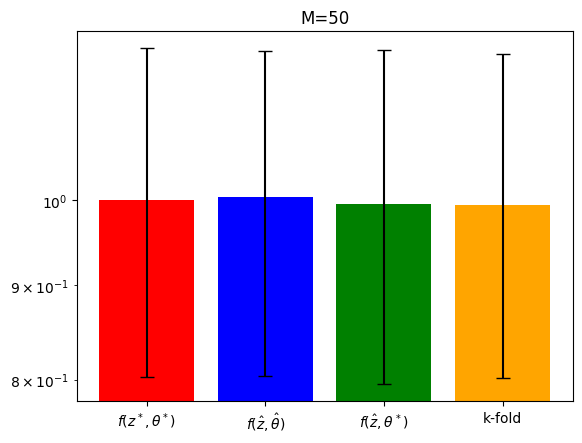

In [11]:
# 棒グラフのデータ
labels = [
    r"$f(z^*,\theta^*)$",
    r"$f(\hat{z},\hat\theta)$",
    r"$f(\hat{z},\theta^*)$",
    r"k-fold",
]
means = np.array(
    [
        np.mean(sales_optimize_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.mean(predict_optimize_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.mean(predict_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.mean(cross_validation_sales_list_50) / np.mean(sales_optimize_sales_list_50),
    ]
)
min_values = np.array(
    [
        np.min(sales_optimize_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.min(predict_optimize_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.min(predict_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.min(cross_validation_sales_list_50) / np.mean(sales_optimize_sales_list_50),
    ]
)
max_values = np.array(
    [
        np.max(sales_optimize_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.max(predict_optimize_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.max(predict_sales_list_50) / np.mean(sales_optimize_sales_list_50),
        np.max(cross_validation_sales_list_50) / np.mean(sales_optimize_sales_list_50),
    ]
)

# エラーバーの計算
yerr = [means - min_values, max_values - means]

# 棒グラフの描画
plt.bar(labels, means, color=["red", "blue", "green", "orange"], yerr=yerr, capsize=5)
plt.yscale("log")
plt.title("M=50")

plt.show()

<BarContainer object of 4 artists>

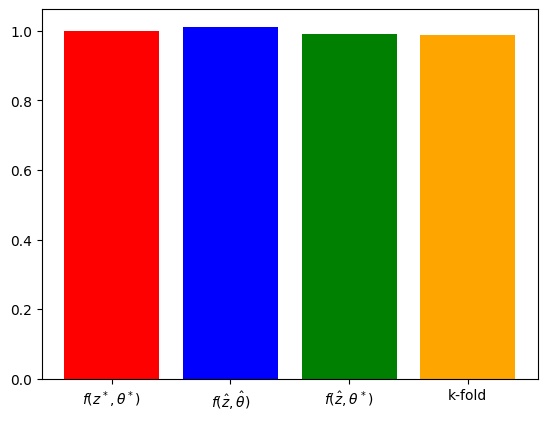

In [12]:
# 100回繰り返して結果をlistに格納
sales_optimize_sales_list_20 = []
predict_optimize_sales_list_20 = []
predict_sales_list_20 = []
cross_validation_sales_list_20 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 20
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # predict_optimazeの結果を取得
    predict_optimize_sales, predict_optimize_prices = predict_optimize(M, X, y, z)
    # sales_optimizeの結果を取得
    sales_optimize_sales, sales_optimize_prices = sales_optimize(M, alpha, beta, z)
    # cross_validationの結果を取得
    cross_validation_sales = cross_validation(X, y, M, 5, z)

    # predictoptimize_salesをsales_functionに代入
    predict_sales = sum(sales_function(predict_optimize_prices, alpha, beta))

    sales_optimize_sales_list_20.append(sales_optimize_sales)
    predict_optimize_sales_list_20.append(predict_optimize_sales)
    predict_sales_list_20.append(predict_sales)
    cross_validation_sales_list_20.append(cross_validation_sales)

# 結果を図示(平均)
plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_optimize_sales_list_20) / np.mean(sales_optimize_sales_list_20),
        np.mean(predict_optimize_sales_list_20) / np.mean(sales_optimize_sales_list_20),
        np.mean(predict_sales_list_20) / np.mean(sales_optimize_sales_list_20),
        np.mean(cross_validation_sales_list_20) / np.mean(sales_optimize_sales_list_20),
    ],
    color=["red", "blue", "green", "orange"],
)

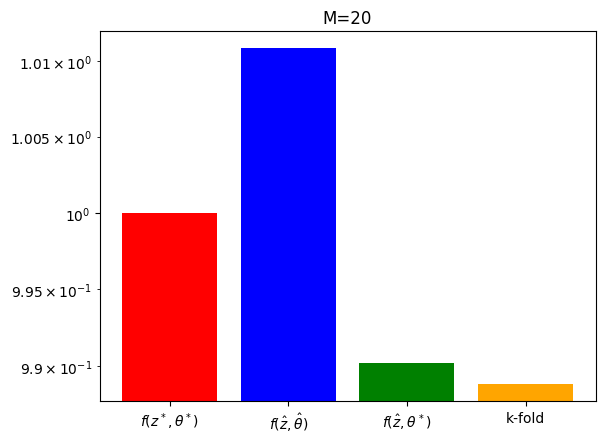

In [13]:
# 結果を図示(平均)
plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_optimize_sales_list_20) / np.mean(sales_optimize_sales_list_20),
        np.mean(predict_optimize_sales_list_20) / np.mean(sales_optimize_sales_list_20),
        np.mean(predict_sales_list_20) / np.mean(sales_optimize_sales_list_20),
        np.mean(cross_validation_sales_list_20) / np.mean(sales_optimize_sales_list_20),
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")
plt.title("M=20")

plt.show()

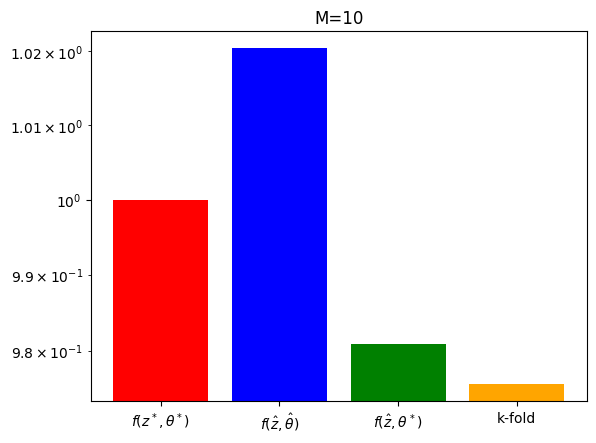

In [14]:
# 100回繰り返して結果をlistに格納
sales_optimize_sales_list_10 = []
predict_optimize_sales_list_10 = []
predict_sales_list_10 = []
cross_validation_sales_list_10 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 10
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # predict_optimazeの結果を取得
    predict_optimize_sales, predict_optimize_prices = predict_optimize(M, X, y, z)
    # sales_optimizeの結果を取得
    sales_optimize_sales, sales_optimize_prices = sales_optimize(M, alpha, beta, z)
    # cross_validationの結果を取得
    cross_validation_sales = cross_validation(X, y, M, 5, z)

    # predictoptimize_salesをsales_functionに代入
    predict_sales = sum(sales_function(predict_optimize_prices, alpha, beta))

    sales_optimize_sales_list_10.append(sales_optimize_sales)
    predict_optimize_sales_list_10.append(predict_optimize_sales)
    predict_sales_list_10.append(predict_sales)
    cross_validation_sales_list_10.append(cross_validation_sales)

# 結果を図示(平均)
plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_optimize_sales_list_10) / np.mean(sales_optimize_sales_list_10),
        np.mean(predict_optimize_sales_list_10) / np.mean(sales_optimize_sales_list_10),
        np.mean(predict_sales_list_10) / np.mean(sales_optimize_sales_list_10),
        np.mean(cross_validation_sales_list_10) / np.mean(sales_optimize_sales_list_10),
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")
plt.title("M=10")

plt.show()

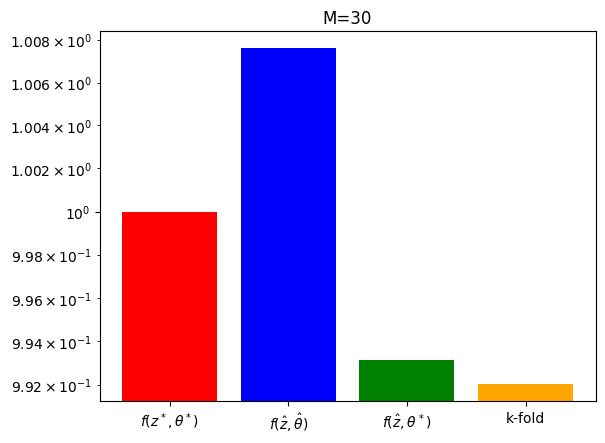

In [15]:
# 100回繰り返して結果をlistに格納
sales_optimize_sales_list_30 = []
predict_optimize_sales_list_30 = []
predict_sales_list_30 = []
cross_validation_sales_list_30 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 30
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # predict_optimazeの結果を取得
    predict_optimize_sales, predict_optimize_prices = predict_optimize(M, X, y, z)
    # sales_optimizeの結果を取得
    sales_optimize_sales, sales_optimize_prices = sales_optimize(M, alpha, beta, z)
    # cross_validationの結果を取得
    cross_validation_sales = cross_validation(X, y, M, 5, z)

    # predictoptimize_salesをsales_functionに代入
    predict_sales = sum(sales_function(predict_optimize_prices, alpha, beta))

    sales_optimize_sales_list_30.append(sales_optimize_sales)
    predict_optimize_sales_list_30.append(predict_optimize_sales)
    predict_sales_list_30.append(predict_sales)
    cross_validation_sales_list_30.append(cross_validation_sales)

# 結果を図示(平均)
plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_optimize_sales_list_30) / np.mean(sales_optimize_sales_list_30),
        np.mean(predict_optimize_sales_list_30) / np.mean(sales_optimize_sales_list_30),
        np.mean(predict_sales_list_30) / np.mean(sales_optimize_sales_list_30),
        np.mean(cross_validation_sales_list_30) / np.mean(sales_optimize_sales_list_30),
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")
plt.title("M=30")

plt.show()

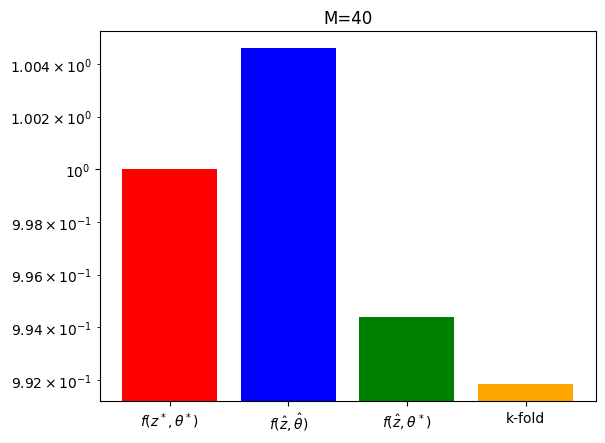

In [16]:
# 100回繰り返して結果をlistに格納
sales_optimize_sales_list_40 = []
predict_optimize_sales_list_40 = []
predict_sales_list_40 = []
cross_validation_sales_list_40 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 40
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # predict_optimazeの結果を取得
    predict_optimize_sales, predict_optimize_prices = predict_optimize(M, X, y, z)
    # sales_optimizeの結果を取得
    sales_optimize_sales, sales_optimize_prices = sales_optimize(M, alpha, beta, z)
    # cross_validationの結果を取得
    cross_validation_sales = cross_validation(X, y, M, 5, z)

    # predictoptimize_salesをsales_functionに代入
    predict_sales = sum(sales_function(predict_optimize_prices, alpha, beta))

    sales_optimize_sales_list_40.append(sales_optimize_sales)
    predict_optimize_sales_list_40.append(predict_optimize_sales)
    predict_sales_list_40.append(predict_sales)
    cross_validation_sales_list_40.append(cross_validation_sales)

# 結果を図示(平均)
plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_optimize_sales_list_40) / np.mean(sales_optimize_sales_list_40),
        np.mean(predict_optimize_sales_list_40) / np.mean(sales_optimize_sales_list_40),
        np.mean(predict_sales_list_40) / np.mean(sales_optimize_sales_list_40),
        np.mean(cross_validation_sales_list_40) / np.mean(sales_optimize_sales_list_40),
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")
plt.title("M=40")

plt.show()

In [17]:
# 得られたすべてのlistの平均をと分散を表形式で表示
df = pd.DataFrame(
    {
        "M=10": [
            np.mean(sales_optimize_sales_list_10),
            np.mean(predict_optimize_sales_list_10),
            np.mean(predict_sales_list_10),
            np.mean(cross_validation_sales_list_10),
        ],
        "M=20": [
            np.mean(sales_optimize_sales_list_20),
            np.mean(predict_optimize_sales_list_20),
            np.mean(predict_sales_list_20),
            np.mean(cross_validation_sales_list_20),
        ],
        "M=30": [
            np.mean(sales_optimize_sales_list_30),
            np.mean(predict_optimize_sales_list_30),
            np.mean(predict_sales_list_30),
            np.mean(cross_validation_sales_list_30),
        ],
        "M=40": [
            np.mean(sales_optimize_sales_list_40),
            np.mean(predict_optimize_sales_list_40),
            np.mean(predict_sales_list_40),
            np.mean(cross_validation_sales_list_40),
        ],
        "M=50": [
            np.mean(sales_optimize_sales_list_50),
            np.mean(predict_optimize_sales_list_50),
            np.mean(predict_sales_list_50),
            np.mean(cross_validation_sales_list_50),
        ],
    },
    index=[
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
)
df

,M=10,M=20,M=30,M=40,M=50
"$f(z^*,\theta^*)$",101.221106,408.426177,934.532082,1668.975538,2640.520759
"$f(\hat{z},\hat\theta)$",103.287182,412.856385,941.637024,1676.681541,2651.323465
"$f(\hat{z},\theta^*)$",99.290182,404.420463,928.121956,1659.641443,2629.241351
k-fold,98.753803,403.864495,927.077835,1655.380156,2624.620980


In [18]:
def predict_neldar(M: int, X: np.ndarray, Y: np.ndarray, prices_list: list[float]):
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)

    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    def objective_function(prices):
        return -sum(
            prices[m]
            * (intercepts[m] + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M)))
            for m in range(M)
        )

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.8)

    # Nelder-Mead法を使用した最適化
    result = minimize(
        objective_function,
        initial_prices,
        method="Nelder-Mead",
        bounds=[(0.6, 1.0)] * M,  # assuming r_m = 0.6 and r_M = 1.0
        options={"adaptive": True},
    )

    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

    return optimal_value, optimal_prices

In [19]:
# sales_optimizeの最適化をNelder-Mead法で行う関数
def sales_neldar(
    M: int,
    alpha: np.ndarray,
    beta: np.ndarray,
    prices_list: list[float],
):
    # 目的関数を定義（最大化問題を最小化問題に変換）
    def objective_function(prices):
        return -sum(
            prices[m]
            * (alpha[m] + sum(beta[m][m_prime] * prices[m_prime] for m_prime in range(M)))
            for m in range(M)
        )

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.8)

    # Nelder-Mead法を使用した最適化
    result = minimize(
        objective_function,
        initial_prices,
        method="Nelder-Mead",
        bounds=[(0.6, 1.0)] * M,  # assuming r_m = 0.6 and r_M = 1.0
        options={"adaptive": True},
    )

    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

    return optimal_value, optimal_prices

In [20]:
# CVを行う関数（Nelder-Mead法を使用）
def cv_neldar(
    X: np.ndarray,
    y: np.ndarray,
    M: int,
    K: int,
    prices_list: list[float],
) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())
        lr_tilda.fit(X_train, y_train)

        # 係数、切片を取得
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        def objective_function(prices):
            return -sum(
                prices[m]
                * (
                    intercepts[m]
                    + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M))
                )
                for m in range(M)
            )

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.8)

        # Nelder-Mead法を使用した最適化
        result = minimize(
            objective_function,
            initial_prices,
            method="Nelder-Mead",
            bounds=[(0.6, 1.0)] * M,  # assuming r_m = 0.6 and r_M = 1.0
            options={"adaptive": True},
        )

        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        # 最適な価格を基に予測
        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)

Text(0.5, 1.0, 'M=10')

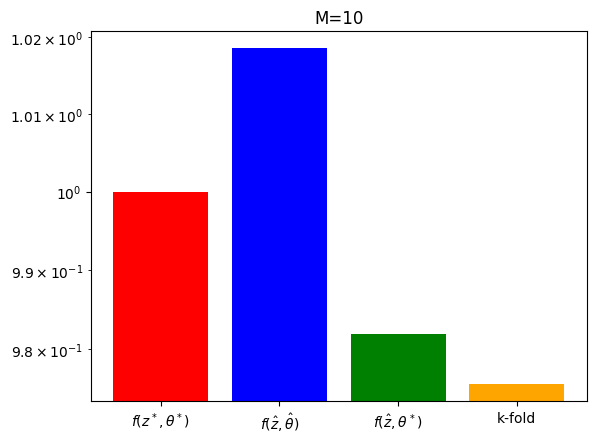

In [21]:
# 100回繰り返して結果をlistに格納
sales_neldar_sales_list_10 = []
predict_neldar_sales_list_10 = []
predict_sales_list_10_neldar = []
cv_neldar_sales_list_10 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 10
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # predict_neldarの結果を取得
    predict_neldar_sales, predict_neldar_prices = predict_neldar(M, X, y, z)

    # sales_neldarの結果を取得
    sales_neldar_sales, sales_neldar_prices = sales_neldar(M, alpha, beta, z)

    # cv_neldarの結果を取得
    cv_neldar_sales = cv_neldar(X, y, M, 5, z)

    # predict_neldarの結果をsales_functionに代入
    predict_sales = sum(sales_function(predict_neldar_prices, alpha, beta))

    sales_neldar_sales_list_10.append(sales_neldar_sales)
    predict_neldar_sales_list_10.append(predict_neldar_sales)
    predict_sales_list_10_neldar.append(predict_sales)
    cv_neldar_sales_list_10.append(cv_neldar_sales)

# 結果を図示(平均)

plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_neldar_sales_list_10) / np.mean(sales_neldar_sales_list_10),
        np.mean(predict_neldar_sales_list_10) / np.mean(sales_neldar_sales_list_10),
        np.mean(predict_sales_list_10_neldar) / np.mean(sales_neldar_sales_list_10),
        np.mean(cv_neldar_sales_list_10) / np.mean(sales_neldar_sales_list_10),
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")
plt.title("M=10")

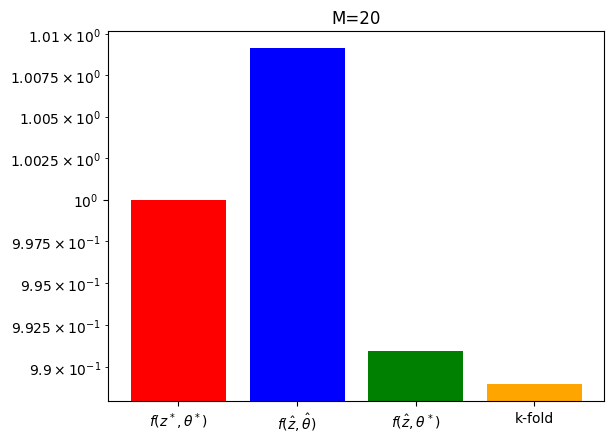

In [22]:
# M=20で100回
sales_neldar_sales_list_20 = []
predict_neldar_sales_list_20 = []
predict_sales_list_20_neldar = []
cv_neldar_sales_list_20 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 20
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # predict_neldarの結果を取得
    predict_neldar_sales, predict_neldar_prices = predict_neldar(M, X, y, z)

    # sales_neldarの結果を取得
    sales_neldar_sales, sales_neldar_prices = sales_neldar(M, alpha, beta, z)

    # cv_neldarの結果を取得
    cv_neldar_sales = cv_neldar(X, y, M, 5, z)

    # predict_neldarの結果をsales_functionに代入
    predict_sales = sum(sales_function(predict_neldar_prices, alpha, beta))

    sales_neldar_sales_list_20.append(sales_neldar_sales)
    predict_neldar_sales_list_20.append(predict_neldar_sales)
    predict_sales_list_20_neldar.append(predict_sales)
    cv_neldar_sales_list_20.append(cv_neldar_sales)

# 結果を図示(平均)

plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_neldar_sales_list_20) / np.mean(sales_neldar_sales_list_20),
        np.mean(predict_neldar_sales_list_20) / np.mean(sales_neldar_sales_list_20),
        np.mean(predict_sales_list_20_neldar) / np.mean(sales_neldar_sales_list_20),
        np.mean(cv_neldar_sales_list_20) / np.mean(sales_neldar_sales_list_20),
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")
plt.title("M=20")

plt.show()

Text(0.5, 1.0, 'M=30')

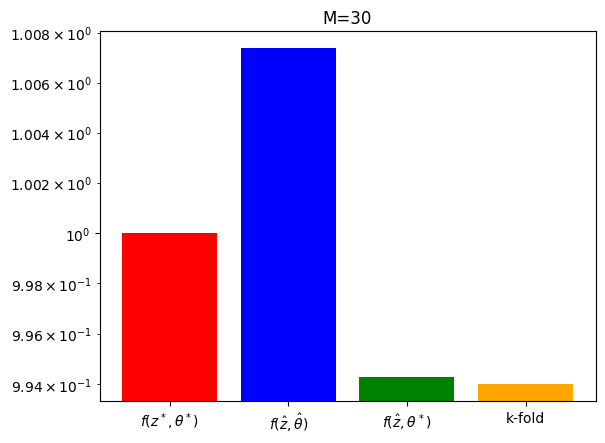

In [23]:
# M=30で100回
sales_neldar_sales_list_30 = []
predict_neldar_sales_list_30 = []
predict_sales_list_30_neldar = []
cv_neldar_sales_list_30 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 30
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # predict_neldarの結果を取得
    predict_neldar_sales, predict_neldar_prices = predict_neldar(M, X, y, z)

    # sales_neldarの結果を取得
    sales_neldar_sales, sales_neldar_prices = sales_neldar(M, alpha, beta, z)

    # cv_neldarの結果を取得
    cv_neldar_sales = cv_neldar(X, y, M, 5, z)

    # predict_neldarの結果をsales_functionに代入
    predict_sales = sum(sales_function(predict_neldar_prices, alpha, beta))

    sales_neldar_sales_list_30.append(sales_neldar_sales)
    predict_neldar_sales_list_30.append(predict_neldar_sales)
    predict_sales_list_30_neldar.append(predict_sales)
    cv_neldar_sales_list_30.append(cv_neldar_sales)

# 結果を図示(平均)

plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_neldar_sales_list_30) / np.mean(sales_neldar_sales_list_30),
        np.mean(predict_neldar_sales_list_30) / np.mean(sales_neldar_sales_list_30),
        np.mean(predict_sales_list_30_neldar) / np.mean(sales_neldar_sales_list_30),
        np.mean(cv_neldar_sales_list_30) / np.mean(sales_neldar_sales_list_30),
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")
plt.title("M=30")

Text(0.5, 1.0, 'M=40')

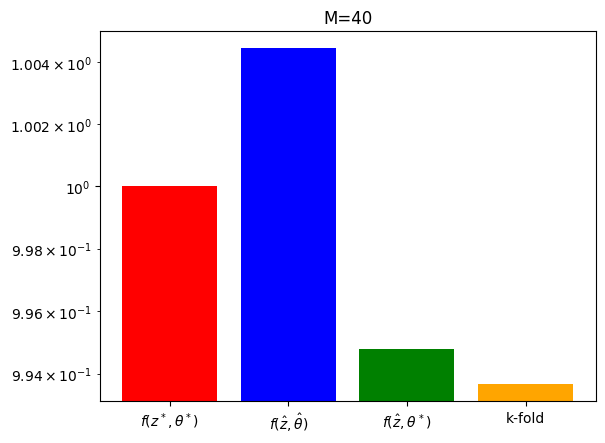

In [24]:
# M=40で100回
sales_neldar_sales_list_40 = []
predict_neldar_sales_list_40 = []
predict_sales_list_40_neldar = []
cv_neldar_sales_list_40 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 40
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # predict_neldarの結果を取得
    predict_neldar_sales, predict_neldar_prices = predict_neldar(M, X, y, z)

    # sales_neldarの結果を取得
    sales_neldar_sales, sales_neldar_prices = sales_neldar(M, alpha, beta, z)

    # cv_neldarの結果を取得
    cv_neldar_sales = cv_neldar(X, y, M, 5, z)

    # predict_neldarの結果をsales_functionに代入
    predict_sales = sum(sales_function(predict_neldar_prices, alpha, beta))

    sales_neldar_sales_list_40.append(sales_neldar_sales)
    predict_neldar_sales_list_40.append(predict_neldar_sales)
    predict_sales_list_40_neldar.append(predict_sales)
    cv_neldar_sales_list_40.append(cv_neldar_sales)

# 結果を図示(平均)

plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_neldar_sales_list_40) / np.mean(sales_neldar_sales_list_40),
        np.mean(predict_neldar_sales_list_40) / np.mean(sales_neldar_sales_list_40),
        np.mean(predict_sales_list_40_neldar) / np.mean(sales_neldar_sales_list_40),
        np.mean(cv_neldar_sales_list_40) / np.mean(sales_neldar_sales_list_40),
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")
plt.title("M=40")

In [25]:
# M=50で100回
sales_neldar_sales_list_50 = []
predict_neldar_sales_list_50 = []
predict_sales_list_50_neldar = []
cv_neldar_sales_list_50 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 50
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # predict_neldarの結果を取得
    predict_neldar_sales, predict_neldar_prices = predict_neldar(M, X, y, z)

    # sales_neldarの結果を取得
    sales_neldar_sales, sales_neldar_prices = sales_neldar(M, alpha, beta, z)

    # cv_neldarの結果を取得
    cv_neldar_sales = cv_neldar(X, y, M, 5, z)

    # predict_neldarの結果をsales_functionに代入
    predict_sales = sum(sales_function(predict_neldar_prices, alpha, beta))

    sales_neldar_sales_list_50.append(sales_neldar_sales)
    predict_neldar_sales_list_50.append(predict_neldar_sales)
    predict_sales_list_50_neldar.append(predict_sales)
    cv_neldar_sales_list_50.append(cv_neldar_sales)

# 結果を図示(平均)

plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_neldar_sales_list_50) / np.mean(sales_neldar_sales_list_50),
        np.mean(predict_neldar_sales_list_50) / np.mean(sales_neldar_sales_list_50),
        np.mean(predict_sales_list_50_neldar) / np.mean(sales_neldar_sales_list_50),
        np.mean(cv_neldar_sales_list_50) / np.mean(sales_neldar_sales_list_50),
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")
plt.title("M=50")

KeyboardInterrupt: 

In [26]:
# 取得した全てのlistの平均と分散を表形式で表示
sales_neldar_sales_list = [
    sales_neldar_sales_list_10,
    sales_neldar_sales_list_20,
    sales_neldar_sales_list_30,
    sales_neldar_sales_list_40,
]

predict_neldar_sales_list = [
    predict_neldar_sales_list_10,
    predict_neldar_sales_list_20,
    predict_neldar_sales_list_30,
    predict_neldar_sales_list_40,
]

predict_sales_list_neldar = [
    predict_sales_list_10_neldar,
    predict_sales_list_20_neldar,
    predict_sales_list_30_neldar,
    predict_sales_list_40_neldar,
]

cv_neldar_sales_list = [
    cv_neldar_sales_list_10,
    cv_neldar_sales_list_20,
    cv_neldar_sales_list_30,
    cv_neldar_sales_list_40,
]

sales_neldar_sales_mean = [np.mean(sales) for sales in sales_neldar_sales_list]
predict_neldar_sales_mean = [np.mean(sales) for sales in predict_neldar_sales_list]
predict_sales_mean_neldar = [np.mean(sales) for sales in predict_sales_list_neldar]
cv_neldar_sales_mean = [np.mean(sales) for sales in cv_neldar_sales_list]

sales_neldar_sales_var = [np.var(sales) for sales in sales_neldar_sales_list]
predict_neldar_sales_var = [np.var(sales) for sales in predict_neldar_sales_list]
predict_sales_var_neldar = [np.var(sales) for sales in predict_sales_list_neldar]
cv_neldar_sales_var = [np.var(sales) for sales in cv_neldar_sales_list]

df_neldar = pd.DataFrame(
    {
        "M": [10, 20, 30, 40],
        "sales_neldar_mean": sales_neldar_sales_mean,
        "sales_neldar_var": sales_neldar_sales_var,
        "predict_neldar_mean": predict_neldar_sales_mean,
        "predict_neldar_var": predict_neldar_sales_var,
        "predict_sales_mean_neldar": predict_sales_mean_neldar,
        "predict_sales_var_neldar": predict_sales_var_neldar,
        "cv_neldar_mean": cv_neldar_sales_mean,
        "cv_neldar_var": cv_neldar_sales_var,
    }
)

print(df_neldar)

    M  sales_neldar_mean  sales_neldar_var  predict_neldar_mean  \
0  10          99.837442        292.521908           101.687740   
1  20         413.418740       2470.967242           417.192198   
2  30         928.914513       7643.680588           935.762799   
3  40        1659.603854      17083.864677          1666.982782   

   predict_neldar_var  predict_sales_mean_neldar  predict_sales_var_neldar  \
0          297.654374                  98.032814                298.595335   
1         2482.122962                 409.682302               2494.437918   
2         7899.743146                 923.599601               7803.943245   
3        16800.221960                1650.961587              17032.526150   

   cv_neldar_mean  cv_neldar_var  
0       97.404096     315.421930  
1      408.868178    2614.663178  
2      923.345316    7980.872576  
3     1649.087728   17242.177518  


In [27]:
df_neldar

,M,sales_neldar_mean,sales_neldar_var,predict_neldar_mean,predict_neldar_var,predict_sales_mean_neldar,predict_sales_var_neldar,cv_neldar_mean,cv_neldar_var
0,10,99.837442,292.521908,101.687740,297.654374,98.032814,298.595335,97.404096,315.421930
1,20,413.418740,2470.967242,417.192198,2482.122962,409.682302,2494.437918,408.868178,2614.663178
2,30,928.914513,7643.680588,935.762799,7899.743146,923.599601,7803.943245,923.345316,7980.872576
3,40,1659.603854,17083.864677,1666.982782,16800.221960,1650.961587,17032.526150,1649.087728,17242.177518


In [28]:
# df_neldarをcsvファイルに出力
df_neldar.to_csv("df_neldar.csv")


In [29]:
# df_SLSQPを作成
sales_optimize_sales_list = [
    sales_optimize_sales_list_10,
    sales_optimize_sales_list_20,
    sales_optimize_sales_list_30,
    sales_optimize_sales_list_40,
]

predict_optimize_sales_list = [
    predict_optimize_sales_list_10,
    predict_optimize_sales_list_20,
    predict_optimize_sales_list_30,
    predict_optimize_sales_list_40,
]

predict_sales_list = [
    predict_sales_list_10,
    predict_sales_list_20,
    predict_sales_list_30,
    predict_sales_list_40,
]

cross_validation_sales_list = [
    cross_validation_sales_list_10,
    cross_validation_sales_list_20,
    cross_validation_sales_list_30,
    cross_validation_sales_list_40,
]

sales_optimize_sales_mean = [np.mean(sales) for sales in sales_optimize_sales_list]
predict_optimize_sales_mean = [np.mean(sales) for sales in predict_optimize_sales_list]
predict_sales_mean = [np.mean(sales) for sales in predict_sales_list]
cross_validation_sales_mean = [np.mean(sales) for sales in cross_validation_sales_list]

sales_optimize_sales_var = [np.var(sales) for sales in sales_optimize_sales_list]
predict_optimize_sales_var = [np.var(sales) for sales in predict_optimize_sales_list]
predict_sales_var = [np.var(sales) for sales in predict_sales_list]
cross_validation_sales_var = [np.var(sales) for sales in cross_validation_sales_list]

df_SLSQP = pd.DataFrame(
    {
        "M": [10, 20, 30, 40],
        "sales_optimize_mean": sales_optimize_sales_mean,
        "sales_optimize_var": sales_optimize_sales_var,
        "predict_optimize_mean": predict_optimize_sales_mean,
        "predict_optimize_var": predict_optimize_sales_var,
        "predict_sales_mean": predict_sales_mean,
        "predict_sales_var": predict_sales_var,
        "cross_validation_mean": cross_validation_sales_mean,
        "cross_validation_var": cross_validation_sales_var,
    }
)

print(df_SLSQP)

# df_SLSQPをcsvファイルに出力
df_SLSQP.to_csv("df_SLSQP.csv")


    M  sales_optimize_mean  sales_optimize_var  predict_optimize_mean  \
0  10           101.221106          296.704630             103.287182   
1  20           408.426177         2178.335628             412.856385   
2  30           934.532082         8682.058208             941.637024   
3  40          1668.975538        14695.608248            1676.681541   

   predict_optimize_var  predict_sales_mean  predict_sales_var  \
0            291.887411           99.290182         301.289758   
1           2228.151177          404.420463        2206.473391   
2           8724.379668          928.121956        8770.901057   
3          14306.434268         1659.641443       14759.664768   

   cross_validation_mean  cross_validation_var  
0              98.753803            298.134555  
1             403.864495           2348.534946  
2             927.077835           8974.926096  
3            1655.380156          14519.916299  


In [30]:
def pred_bfgs(M: int, X: np.ndarray, Y: np.ndarray, prices_list: list[float]):
    lr = MultiOutputRegressor(LinearRegression())
    lr.fit(X, Y)

    # 係数と切片を取得
    coefs = [estimate.coef_ for estimate in lr.estimators_]
    intercepts = [estimate.intercept_ for estimate in lr.estimators_]

    def objective_function(prices):
        return -sum(
            prices[m]
            * (intercepts[m] + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M)))
            for m in range(M)
        )

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.8)

    # L-BFGS-B法を使用した最適化
    result = minimize(
        objective_function,
        initial_prices,
        method="L-BFGS-B",
        bounds=[(0.6, 1.0)] * M,  # assuming r_m = 0.6 and r_M = 1.0
        options={"disp": True},
    )

    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

    return optimal_value, optimal_prices


In [31]:
def sales_bfgs(M: int, alpha: np.ndarray, beta: np.ndarray, prices_list: list[float]):
    # 目的関数を定義（最大化問題を最小化問題に変換）
    def objective_function(prices):
        return -sum(
            prices[m]
            * (alpha[m] + sum(beta[m][m_prime] * prices[m_prime] for m_prime in range(M)))
            for m in range(M)
        )

    # 初期値として与えられたprices_listを使用
    initial_prices = np.full(M, 0.8)

    # L-BFGS-B法を使用した最適化
    result = minimize(
        objective_function,
        initial_prices,
        method="L-BFGS-B",
        bounds=[(0.6, 1.0)] * M,  # assuming r_m = 0.6 and r_M = 1.0
        options={"disp": True},
    )

    # 最適な価格と目的関数の値を取得
    optimal_prices = result.x
    optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

    return optimal_value, optimal_prices


In [32]:
def cv_bfgs(X: np.ndarray, y: np.ndarray, M: int, K: int, prices_list: list[float]) -> float:
    kf = KFold(n_splits=K, shuffle=True, random_state=0)
    optimal_sales_list = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # trainで学習
        lr_tilda = MultiOutputRegressor(LinearRegression())
        lr_tilda.fit(X_train, y_train)

        # 係数、切片を取得
        coefs = [estimate.coef_ for estimate in lr_tilda.estimators_]
        intercepts = [estimate.intercept_ for estimate in lr_tilda.estimators_]

        def objective_function(prices):
            return -sum(
                prices[m]
                * (
                    intercepts[m]
                    + sum(coefs[m][m_prime] * prices[m_prime] for m_prime in range(M))
                )
                for m in range(M)
            )

        # 初期値として与えられたprices_listを使用
        initial_prices = np.full(M, 0.8)

        # L-BFGS-B法を使用した最適化
        result = minimize(
            objective_function,
            initial_prices,
            method="L-BFGS-B",
            bounds=[(0.6, 1.0)] * M,  # assuming r_m = 0.6 and r_M = 1.0
            options={"disp": True},
        )

        # 最適な価格と目的関数の値を取得
        optimal_prices = result.x
        optimal_value = -result.fun  # 符号を反転して元の最大化問題の値に戻す

        # testで学習
        lr_hat = MultiOutputRegressor(LinearRegression())
        lr_hat.fit(X_test, y_test)

        # 最適な価格を基に予測
        quantity_hat = lr_hat.predict([optimal_prices])
        sales_hat = np.sum(quantity_hat * optimal_prices)

        optimal_sales_list.append(sales_hat)

    return np.mean(optimal_sales_list)


Text(0.5, 1.0, 'M=10')

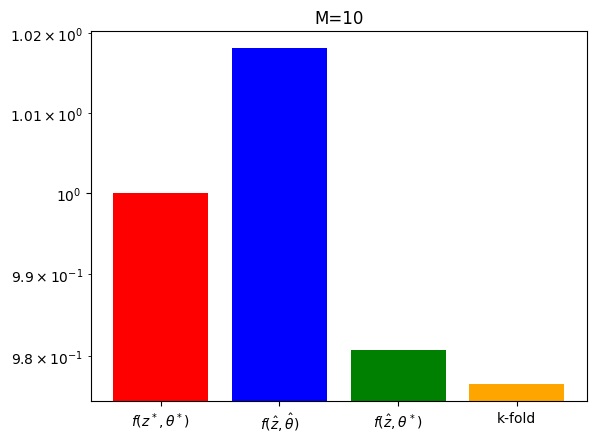

In [52]:
# M=10において100回
sales_bfgs_sales_list_10 = []
predict_bfgs_sales_list_10 = []
predict_sales_list_10_bfgs = []
cv_bfgs_sales_list_10 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 10
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # pred_bfgsの結果を取得
    predict_bfgs_sales, predict_bfgs_prices = pred_bfgs(M, X, y, z)

    # sales_bfgsの結果を取得
    sales_bfgs_sales, sales_bfgs_prices = sales_bfgs(M, alpha, beta, z)

    # cv_bfgsの結果を取得
    cv_bfgs_sales = cv_bfgs(X, y, M, 5, z)

    # pred_bfgsの結果をsales_functionに代入
    predict_sales = sum(sales_function(predict_bfgs_prices, alpha, beta))

    sales_bfgs_sales_list_10.append(sales_bfgs_sales)
    predict_bfgs_sales_list_10.append(predict_bfgs_sales)
    predict_sales_list_10_bfgs.append(predict_sales)
    cv_bfgs_sales_list_10.append(cv_bfgs_sales)

# 結果を図示(平均)

plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_bfgs_sales_list_10) / np.mean(sales_bfgs_sales_list_10),
        np.mean(predict_bfgs_sales_list_10) / np.mean(sales_bfgs_sales_list_10),
        np.mean(predict_sales_list_10_bfgs) / np.mean(sales_bfgs_sales_list_10),
        np.mean(cv_bfgs_sales_list_10) / np.mean(sales_bfgs_sales_list_10),
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")
plt.title("M=10")


Text(0.5, 1.0, 'M=20')

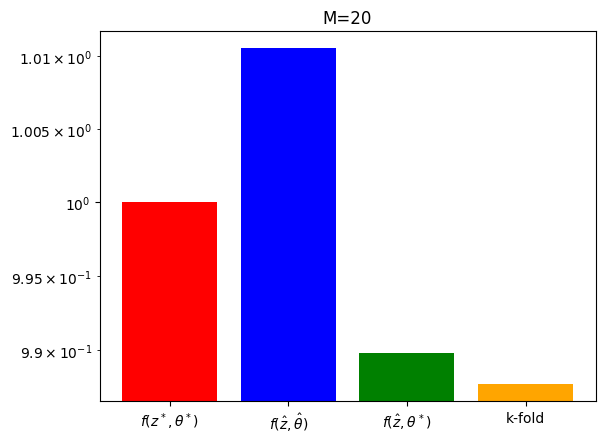

In [35]:
# M=20において100回
sales_bfgs_sales_list_20 = []
predict_bfgs_sales_list_20 = []
predict_sales_list_20_bfgs = []
cv_bfgs_sales_list_20 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 20
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # pred_bfgsの結果を取得
    predict_bfgs_sales, predict_bfgs_prices = pred_bfgs(M, X, y, z)

    # sales_bfgsの結果を取得
    sales_bfgs_sales, sales_bfgs_prices = sales_bfgs(M, alpha, beta, z)

    # cv_bfgsの結果を取得
    cv_bfgs_sales = cv_bfgs(X, y, M, 5, z)

    # pred_bfgsの結果をsales_functionに代入
    predict_sales = sum(sales_function(predict_bfgs_prices, alpha, beta))

    sales_bfgs_sales_list_20.append(sales_bfgs_sales)
    predict_bfgs_sales_list_20.append(predict_bfgs_sales)
    predict_sales_list_20_bfgs.append(predict_sales)
    cv_bfgs_sales_list_20.append(cv_bfgs_sales)

# 結果を図示(平均)

plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_bfgs_sales_list_20) / np.mean(sales_bfgs_sales_list_20),
        np.mean(predict_bfgs_sales_list_20) / np.mean(sales_bfgs_sales_list_20),
        np.mean(predict_sales_list_20_bfgs) / np.mean(sales_bfgs_sales_list_20),
        np.mean(cv_bfgs_sales_list_20) / np.mean(sales_bfgs_sales_list_20),
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")
plt.title("M=20")


Text(0.5, 1.0, 'M=30')

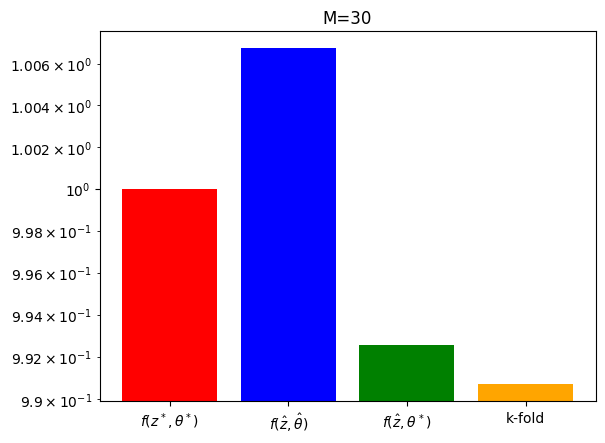

In [36]:
# M=30で100回
sales_bfgs_sales_list_30 = []
predict_bfgs_sales_list_30 = []
predict_sales_list_30_bfgs = []
cv_bfgs_sales_list_30 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 30
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # pred_bfgsの結果を取得
    predict_bfgs_sales, predict_bfgs_prices = pred_bfgs(M, X, y, z)

    # sales_bfgsの結果を取得
    sales_bfgs_sales, sales_bfgs_prices = sales_bfgs(M, alpha, beta, z)

    # cv_bfgsの結果を取得
    cv_bfgs_sales = cv_bfgs(X, y, M, 5, z)

    # pred_bfgsの結果をsales_functionに代入
    predict_sales = sum(sales_function(predict_bfgs_prices, alpha, beta))

    sales_bfgs_sales_list_30.append(sales_bfgs_sales)
    predict_bfgs_sales_list_30.append(predict_bfgs_sales)
    predict_sales_list_30_bfgs.append(predict_sales)
    cv_bfgs_sales_list_30.append(cv_bfgs_sales)

# 結果を図示(平均)

plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_bfgs_sales_list_30) / np.mean(sales_bfgs_sales_list_30),
        np.mean(predict_bfgs_sales_list_30) / np.mean(sales_bfgs_sales_list_30),
        np.mean(predict_sales_list_30_bfgs) / np.mean(sales_bfgs_sales_list_30),
        np.mean(cv_bfgs_sales_list_30) / np.mean(sales_bfgs_sales_list_30),
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")
plt.title("M=30")


Text(0.5, 1.0, 'M=40')

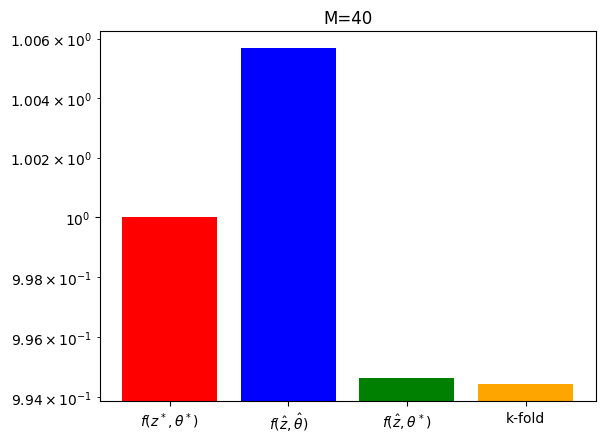

In [37]:
# M=40で100回
sales_bfgs_sales_list_40 = []
predict_bfgs_sales_list_40 = []
predict_sales_list_40_bfgs = []
cv_bfgs_sales_list_40 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 40
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # pred_bfgsの結果を取得
    predict_bfgs_sales, predict_bfgs_prices = pred_bfgs(M, X, y, z)

    # sales_bfgsの結果を取得
    sales_bfgs_sales, sales_bfgs_prices = sales_bfgs(M, alpha, beta, z)

    # cv_bfgsの結果を取得
    cv_bfgs_sales = cv_bfgs(X, y, M, 5, z)

    # pred_bfgsの結果をsales_functionに代入
    predict_sales = sum(sales_function(predict_bfgs_prices, alpha, beta))

    sales_bfgs_sales_list_40.append(sales_bfgs_sales)
    predict_bfgs_sales_list_40.append(predict_bfgs_sales)
    predict_sales_list_40_bfgs.append(predict_sales)
    cv_bfgs_sales_list_40.append(cv_bfgs_sales)

# 結果を図示(平均)

plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta)$",
        r"$f(\hat{z},\theta^*)$",
        r"k-fold",
    ],
    [
        np.mean(sales_bfgs_sales_list_40) / np.mean(sales_bfgs_sales_list_40),
        np.mean(predict_bfgs_sales_list_40) / np.mean(sales_bfgs_sales_list_40),
        np.mean(predict_sales_list_40_bfgs) / np.mean(sales_bfgs_sales_list_40),
        np.mean(cv_bfgs_sales_list_40) / np.mean(sales_bfgs_sales_list_40),
    ],
    color=["red", "blue", "green", "orange"],
)
plt.yscale("log")
plt.title("M=40")


In [38]:
# 平均と分散をdf_bfgsに格納
sales_bfgs_sales_list = [
    sales_bfgs_sales_list_10,
    sales_bfgs_sales_list_20,
    sales_bfgs_sales_list_30,
    sales_bfgs_sales_list_40,
]

predict_bfgs_sales_list = [
    predict_bfgs_sales_list_10,
    predict_bfgs_sales_list_20,
    predict_bfgs_sales_list_30,
    predict_bfgs_sales_list_40,
]

predict_sales_list_bfgs = [
    predict_sales_list_10_bfgs,
    predict_sales_list_20_bfgs,
    predict_sales_list_30_bfgs,
    predict_sales_list_40_bfgs,
]

cv_bfgs_sales_list = [
    cv_bfgs_sales_list_10,
    cv_bfgs_sales_list_20,
    cv_bfgs_sales_list_30,
    cv_bfgs_sales_list_40,
]

sales_bfgs_sales_mean = [np.mean(sales) for sales in sales_bfgs_sales_list]
predict_bfgs_sales_mean = [np.mean(sales) for sales in predict_bfgs_sales_list]
predict_sales_mean_bfgs = [np.mean(sales) for sales in predict_sales_list_bfgs]
cv_bfgs_sales_mean = [np.mean(sales) for sales in cv_bfgs_sales_list]

sales_bfgs_sales_var = [np.var(sales) for sales in sales_bfgs_sales_list]
predict_bfgs_sales_var = [np.var(sales) for sales in predict_bfgs_sales_list]
predict_sales_var_bfgs = [np.var(sales) for sales in predict_sales_list_bfgs]
cv_bfgs_sales_var = [np.var(sales) for sales in cv_bfgs_sales_list]

df_bfgs = pd.DataFrame(
    {
        "M": [10, 20, 30, 40],
        "sales_bfgs_mean": sales_bfgs_sales_mean,
        "sales_bfgs_var": sales_bfgs_sales_var,
        "predict_bfgs_mean": predict_bfgs_sales_mean,
        "predict_bfgs_var": predict_bfgs_sales_var,
        "predict_sales_mean_bfgs": predict_sales_mean_bfgs,
        "predict_sales_var_bfgs": predict_sales_var_bfgs,
        "cv_bfgs_mean": cv_bfgs_sales_mean,
        "cv_bfgs_var": cv_bfgs_sales_var,
    }
)

print(df_bfgs)

# df_bfgsをcsvファイルに出力

df_bfgs.to_csv("df_bfgs.csv")


    M  sales_bfgs_mean  sales_bfgs_var  predict_bfgs_mean  predict_bfgs_var  \
0  10       102.507789      338.218780         104.958278        350.812655   
1  20       408.618907     2595.241805         412.928788       2535.809814   
2  30       920.596221    10523.244313         926.809100      10365.604756   
3  40      1684.328717    16442.849154        1693.884860      16019.651990   

   predict_sales_mean_bfgs  predict_sales_var_bfgs  cv_bfgs_mean   cv_bfgs_var  
0               100.660994              348.421074    100.939660    374.236768  
1               404.449196             2613.487486    403.589403   2650.163040  
2               913.730101            10701.543001    912.027206  10591.655413  
3              1675.305579            16527.726165   1674.961826  15978.923147  


In [40]:
# M=20において同じデータに対して100回(preddict_optimizeとpred_neldar,pred_bfgsの比較)
sales_optimize_sales_list_20 = []
predict_optimize_sales_list_20 = []
predict_neldar_sales_list_20 = []
predict_bfgs_sales_list_20 = []
predict_sales_list_20 = []
predict_sales_list_20_neldar = []
predict_sales_list_20_bfgs = []
cross_validation_sales_list_20 = []
cv_neldar_sales_list_20 = []
cv_bfgs_sales_list_20 = []

for i in range(100):
    # このデータにおけるalpha,betaを作成
    M = 20
    alpha = alpha_star(M)
    beta = beta_star(M, M)
    r_m = 0.6
    r_M = 1.0
    # 価格を入れるリスト
    price_list = []
    # 売上を入れるリスト
    sales_list = []

    # 価格と対応する売上を500件生成
    for i in range(500):
        price = create_price(r_m, r_M, M)
        price_list.append(price)
        sales = quantity_function(price, alpha, beta)
        sales_list.append(sales)

    X = np.array(price_list).astype(float)
    y = np.array(sales_list).astype(float)

    z = [0.6, 0.7, 0.8, 0.9, 1.0]

    # pred_optimizeの結果を取得
    predict_optimize_sales, predict_optimize_prices = predict_optimize(M, X, y, z)

    # pred_neldarの結果を取得
    predict_neldar_sales, predict_neldar_prices = predict_neldar(M, X, y, z)

    # pred_bfgsの結果を取得
    predict_bfgs_sales, predict_bfgs_prices = pred_bfgs(M, X, y, z)

    # sales_optimizeの結果を取得
    sales_optimize_sales, sales_optimize_prices = sales_optimize(M, alpha, beta, z)

    # cv_optimizeの結果を取得
    cross_validation_sales = cross_validation(X, y, M, 5, z)

    # cv_neldarの結果を取得
    cv_neldar_sales = cv_neldar(X, y, M, 5, z)

    # cv_bfgsの結果を取得
    cv_bfgs_sales = cv_bfgs(X, y, M, 5, z)

    # pred_optimizeの結果をsales_functionに代入
    predict_sales = sum(sales_function(predict_optimize_prices, alpha, beta))
    predict_sales_neldar = sum(sales_function(predict_neldar_prices, alpha, beta))
    predict_sales_bfgs = sum(sales_function(predict_bfgs_prices, alpha, beta))

    sales_optimize_sales_list_20.append(sales_optimize_sales)
    predict_optimize_sales_list_20.append(predict_optimize_sales)
    predict_neldar_sales_list_20.append(predict_neldar_sales)
    predict_bfgs_sales_list_20.append(predict_bfgs_sales)
    predict_sales_list_20.append(predict_sales)
    predict_sales_list_20_neldar.append(predict_sales_neldar)
    predict_sales_list_20_bfgs.append(predict_sales_bfgs)
    cross_validation_sales_list_20.append(cross_validation_sales)
    cv_neldar_sales_list_20.append(cv_neldar_sales)
    cv_bfgs_sales_list_20.append(cv_bfgs_sales)


Text(0.5, 1.0, 'compare SLSQP, Neldar, BFGS M=20')

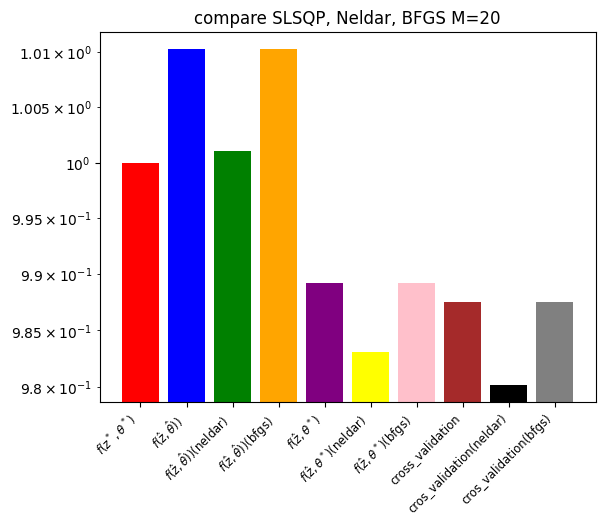

In [50]:
# 結果を図示(平均)
# fig = plt.figure(dpi=150)
plt.bar(
    [
        r"$f(z^*,\theta^*)$",
        r"$f(\hat{z},\hat\theta))$",
        r"$f(\hat{z},\hat\theta))$(neldar)",
        r"$f(\hat{z},\hat\theta))$(bfgs)",
        r"$f(\hat{z},\theta^*)$",
        r"$f(\hat{z},\theta^*)$(neldar)",
        r"$f(\hat{z},\theta^*)$(bfgs)",
        r"cross_validation",
        r"cros_validation(neldar)",
        r"cros_validation(bfgs)",
    ],
    [
        np.mean(sales_optimize_sales_list_20) / np.mean(sales_optimize_sales_list_20),
        np.mean(predict_optimize_sales_list_20) / np.mean(sales_optimize_sales_list_20),
        np.mean(predict_neldar_sales_list_20) / np.mean(sales_optimize_sales_list_20),
        np.mean(predict_bfgs_sales_list_20) / np.mean(sales_optimize_sales_list_20),
        np.mean(predict_sales_list_20) / np.mean(sales_optimize_sales_list_20),
        np.mean(predict_sales_list_20_neldar) / np.mean(sales_optimize_sales_list_20),
        np.mean(predict_sales_list_20_bfgs) / np.mean(sales_optimize_sales_list_20),
        np.mean(cross_validation_sales_list_20) / np.mean(sales_optimize_sales_list_20),
        np.mean(cv_neldar_sales_list_20) / np.mean(sales_optimize_sales_list_20),
        np.mean(cv_bfgs_sales_list_20) / np.mean(sales_optimize_sales_list_20),
    ],
    color=["red", "blue", "green", "orange", "purple", "yellow", "pink", "brown", "black", "gray"],
)
plt.xticks(rotation=45, ha="right", fontsize="small")
plt.yscale("log")
plt.title("compare SLSQP, Neldar, BFGS M=20")


In [53]:
# 各リストの平均と分散を計算
sales_optimize_sales_list_20_mean = np.mean(sales_optimize_sales_list_20)
sales_optimize_sales_list_20_var = np.var(sales_optimize_sales_list_20)

predict_optimize_sales_mean_20 = np.mean(predict_optimize_sales_list_20)
predict_optimize_sales_var_20 = np.var(predict_optimize_sales_list_20)

predict_neldar_sales_mean_20 = np.mean(predict_neldar_sales_list_20)
predict_neldar_sales_var_20 = np.var(predict_neldar_sales_list_20)

predict_bfgs_sales_mean_20 = np.mean(predict_bfgs_sales_list_20)
predict_bfgs_sales_var_20 = np.var(predict_bfgs_sales_list_20)

predict_sales_mean_20 = np.mean(predict_sales_list_20)
predict_sales_var_20 = np.var(predict_sales_list_20)

predict_sales_mean_neldar_20 = np.mean(predict_sales_list_20_neldar)
predict_sales_var_neldar_20 = np.var(predict_sales_list_20_neldar)

predict_sales_mean_bfgs_20 = np.mean(predict_sales_list_20_bfgs)
predict_sales_var_bfgs_20 = np.var(predict_sales_list_20_bfgs)

cross_validation_sales_mean_20 = np.mean(cross_validation_sales_list_20)
cross_validation_sales_var_20 = np.var(cross_validation_sales_list_20)

cv_neldar_sales_mean_20 = np.mean(cv_neldar_sales_list_20)
cv_neldar_sales_var_20 = np.var(cv_neldar_sales_list_20)

cv_bfgs_sales_mean_20 = np.mean(cv_bfgs_sales_list_20)
cv_bfgs_sales_var_20 = np.var(cv_bfgs_sales_list_20)

# 結果をdf_m20に格納
df_m20 = pd.DataFrame(
    {
        "Mean": [
            sales_optimize_sales_list_20_mean,
            predict_optimize_sales_mean_20,
            predict_neldar_sales_mean_20,
            predict_bfgs_sales_mean_20,
            predict_sales_mean_20,
            predict_sales_mean_neldar_20,
            predict_sales_mean_bfgs_20,
            cross_validation_sales_mean_20,
            cv_neldar_sales_mean_20,
            cv_bfgs_sales_mean_20,
        ],
        "Variance": [
            sales_optimize_sales_list_20_var,
            predict_optimize_sales_var_20,
            predict_neldar_sales_var_20,
            predict_bfgs_sales_var_20,
            predict_sales_var_20,
            predict_sales_var_neldar_20,
            predict_sales_var_bfgs_20,
            cross_validation_sales_var_20,
            cv_neldar_sales_var_20,
            cv_bfgs_sales_var_20,
        ],
    },
    index=[
        "sales Optimize",
        "Predict Optimize",
        "Predict Neldar",
        "Predict BFGS",
        "Predict",
        "Predict Neldar (Sales)",
        "Predict BFGS (Sales)",
        "Cross Validation",
        "CV Neldar",
        "CV BFGS",
    ],
)

print(df_m20)

# df_m20をcsvファイルに出力
df_m20.to_csv("df_m20.csv")


                              Mean     Variance
sales Optimize          410.293689  2507.579532
Predict Optimize        414.520426  2535.953811
Predict Neldar          410.725048  2306.220889
Predict BFGS            414.520426  2535.953812
Predict                 405.876156  2556.379705
Predict Neldar (Sales)  403.357236  2357.377096
Predict BFGS (Sales)    405.876162  2556.384091
Cross Validation        405.161329  2648.000919
CV Neldar               402.171144  2378.646824
CV BFGS                 405.161367  2647.997146
